In [10]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.convolution import Gaussian2DKernel,Gaussian1DKernel, convolve, convolve_fft
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import copy

In [11]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_1s_proto.h5", 'r') as hf:
    bias_dc_green_1s = hf['image'][:]

with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_green_3s_proto.h5", 'r') as hf:
    bias_dc_green_3s = hf['image'][:]

In [12]:
class FlatStack:
    def __init__(self,filenames,bias_image,dir=None):
        self.filenames = filenames
        self.bias_image = bias_image
        if dir is not None:
            filepaths = [os.path.join(dir, filename_) for filename_ in filenames]
        else:
            filepaths = filenames
        
        self.n_stack = len(filepaths)
        self.nx = 1392
        self.ny = 1040
        self.image_cube = np.zeros((self.ny,self.nx,self.n_stack))
        self.headers = []

        for ii, filepath in enumerate(filepaths):
            with fits.open(filepath) as hdul:
                self.image_cube[:,:,ii] = hdul[0].data
                self.headers.append(hdul[0].header)


        self.flat_nobias = self.image_cube - self.bias_image[:,:,np.newaxis]

    def calculate_flat(self,method="mean",mask_hot=True,mask_threshold=None,
                mask_sigma=5,kernel_xstd=1,kernel_ystd=1,print_threshold=False):
        # if mask_hot is True:
        #     self.flat_nobias_mask = copy.deepcopy(self.flat_nobias)
        #     for ii in range(self.n_stack):
        #         if mask_threshold is None:
        #             mask_threshold = np.mean(self.flat_nobias[:,:,ii]) + mask_sigma*np.std(self.flat_nobias[:,:,ii])
        #         if print_threshold is True:
        #             print("masked pixels with values > {:.0f}".format(mask_threshold))
        #         mask_pixel = np.where(self.image_cube[:,:,ii] > mask_threshold)
        #         self.image_cube_mask[:,:,ii][mask_pixel] = np.nan
        # else:
        #     self.image_cube_mask = self.image_cube

        self.flat_mask = self.flat_nobias
        if method == "mean":
            self.flat_aver = np.nanmean(self.flat_mask,axis=2)
        elif method == "median":
            self.flat_aver = np.nanmedian(self.flat_mask,axis=2)

        self.flat_norm = self.flat_aver/np.nanmedian(self.flat_aver)

        gaussian_2D_kernel = Gaussian2DKernel(x_stddev=kernel_xstd, y_stddev=kernel_ystd)
        self.flat_smooth = convolve(self.flat_norm, gaussian_2D_kernel,boundary='extend')

    def plot_all(self,bias=False,scale="Zscale",mark_neg=False):
        fig, axes = plt.subplots(self.n_stack,1,figsize=(8,6*self.n_stack + 2),
                    constrained_layout=True)
        
        for ii, ax_ in enumerate(axes):
            if bias is True:
                image_to_plot = self.image_cube[:,:,ii]
            else:
                image_to_plot = self.flat_nobias[:,:,ii]
            if scale == "Zscale":
                norm = ImageNormalize(image_to_plot, interval=ZScaleInterval())
            else:
                norm = None

            im = ax_.pcolormesh(np.arange(self.nx),np.arange(self.ny),image_to_plot,
                                cmap="Greys_r",norm=norm,shading='auto',rasterized=True)

            if mark_neg is True:
                neg_pixel = np.where(image_to_plot < 0)
                ax_.scatter(neg_pixel[1],neg_pixel[0],color="red",marker="+")

            ax_.axis("scaled")
            ax_.set_title(self.filenames[ii])
            
            clb_ax = inset_axes(ax_,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax_.transAxes,
                 borderpad=0)
            clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax_,cax=clb_ax)
            #clb.yaxis.set_minor_locator(AutoMinorLocator(5))

    
    def plot_all_hist(self,bias=False,histmin=1000,histmax=4500):
        fig, ax = plt.subplots(figsize=(8,6))
        if bias is True:
            ax.hist(self.image_cube.reshape(-1,self.n_stack),bins=np.linspace(histmin,histmax,40),
                    histtype="step",label=self.filenames)
        else:
            ax.hist(self.flat_nobias.reshape(-1,self.n_stack),bins=np.linspace(histmin,histmax,40),
                    histtype="step",label=self.filenames)

        ax.legend()

        return ax

    def plot_flat(self,hist_min=0,hist_max=2,scale="Zscale"):
        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,12),constrained_layout=True)
        if scale == "Zscale":
            norm = ImageNormalize(self.flat_norm, interval=ZScaleInterval())
        else:
            norm = None
        im = ax1.pcolormesh(np.arange(self.nx),np.arange(self.ny),self.flat_norm,
                            cmap="Greys_r",norm=norm,shading='auto',rasterized=True)
        clb_ax = inset_axes(ax1,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)
        clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax1,cax=clb_ax)

        ax2.hist(self.flat_norm.flatten(),bins=np.linspace(hist_min,hist_max,40),histtype="step")

        return ax1, ax2

    def plot_flat_smooth(self,hist_min=0,hist_max=2,scale="Zscale"):
        fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,12),constrained_layout=True)
        if scale == "Zscale":
            norm = ImageNormalize(self.flat_smooth, interval=ZScaleInterval())
        else:
            norm = None
        im = ax1.pcolormesh(np.arange(self.nx),np.arange(self.ny),self.flat_smooth,
                            cmap="Greys_r",norm=norm,shading='auto',rasterized=True)
        clb_ax = inset_axes(ax1,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)
        clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax1,cax=clb_ax)

        ax2.hist(self.flat_smooth.flatten(),bins=np.linspace(hist_min,hist_max,40),histtype="step")

        return ax1, ax2
        
    

In [13]:
green_path = "/Users/yjzhu/Desktop/Solar/Eclipse2017/src/EclipseSpectra2017/MikesData/VaderEclipseDayGreen2017aug21/"
fname_skyflat_green_5s = ["SkyGreen5s-better(lightleakcovered)_22840.fit","SkyGreen5s-better(lightleakcovered)_22841.fit",
                        "SkyGreen5s-better(lightleakcovered)_22842.fit","SkyGreen5s-better(lightleakcovered)_22843.fit",
                        "SkyGreen5s-better(lightleakcovered)_22844.fit","SkyGreen5s-better(lightleakcovered)_22845.fit",
                        "SkyGreen5s-better(lightleakcovered)_22846.fit","SkyGreen5s-better(lightleakcovered)_22847.fit",
                        "SkyGreen5s-better(lightleakcovered)_22848.fit","SkyGreen5s-better(lightleakcovered)_22849.fit",
                        "SkyGreen5s-better(lightleakcovered)_22850.fit","SkyGreen5s-better(lightleakcovered)_22851.fit",
                        "SkyGreen5s-better(lightleakcovered)_22852.fit","SkyGreen5s-better(lightleakcovered)_22853.fit",
                        "SkyGreen5s-better(lightleakcovered)_22854.fit"]

In [14]:
skyflat_green_5s_stack = FlatStack(fname_skyflat_green_5s,bias_image=bias_dc_green_3s, dir=green_path)

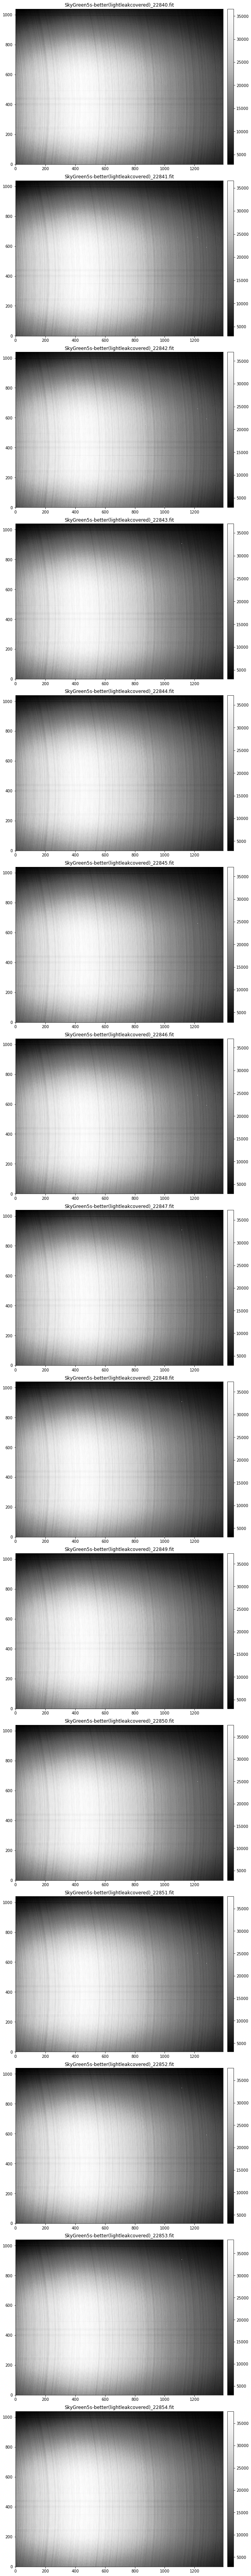

In [15]:
skyflat_green_5s_stack.plot_all(mark_neg=True)

<AxesSubplot:>

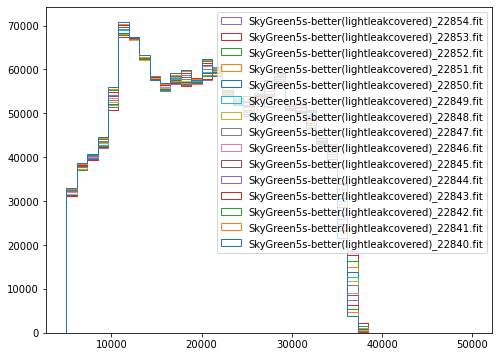

In [16]:
skyflat_green_5s_stack.plot_all_hist(histmin=5000,histmax=50000)

Text(0.5, 1.0, 'Normalized & Smoothed 5s Skyflat')

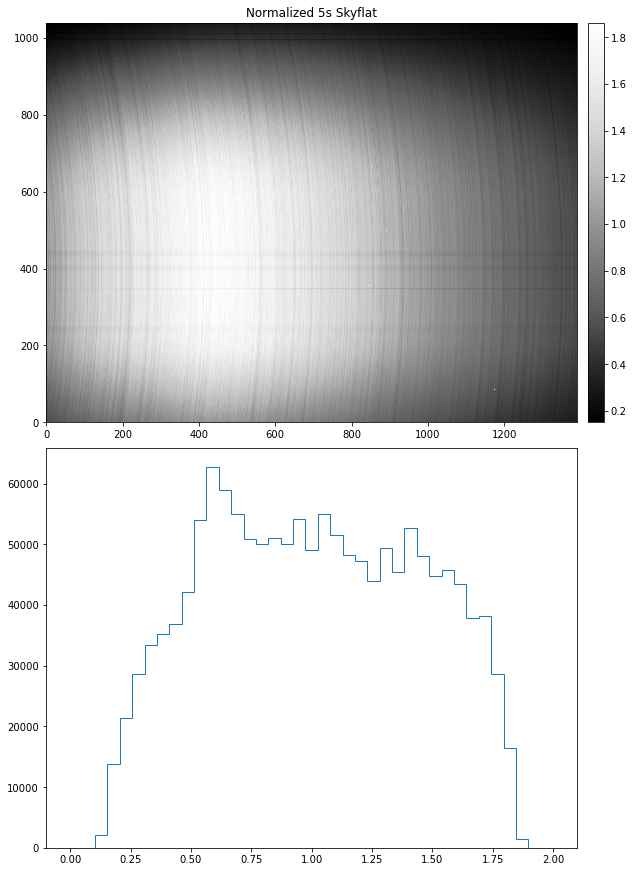

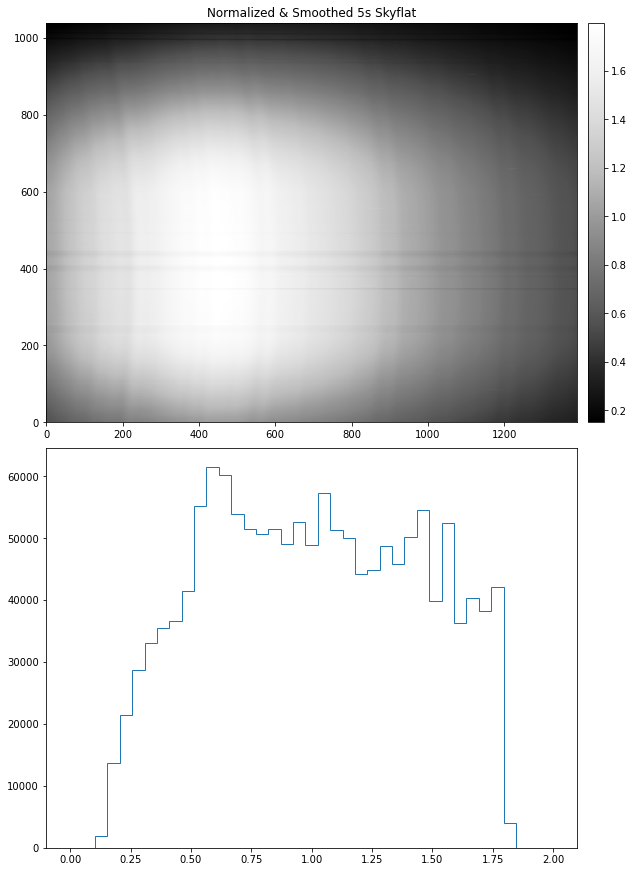

In [17]:
skyflat_green_5s_stack.calculate_flat(kernel_xstd=10,kernel_ystd=1)
ax1, _ = skyflat_green_5s_stack.plot_flat()
ax1.set_title("Normalized 5s Skyflat")
ax1, _ = skyflat_green_5s_stack.plot_flat_smooth()
ax1.set_title("Normalized & Smoothed 5s Skyflat")

In [18]:
skyflat_green_5s_norm = skyflat_green_5s_stack.flat_norm
with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_5s_norm_proto.h5", 'w') as hf:
    hf.create_dataset("image",  data=skyflat_green_5s_norm)